In [330]:
import pandas as pd

In [ ]:
df = pd.read_csv("../Datasets/aegypti.csv")

In [332]:
brazil_df = df[df["COUNTRY"] == "Brazil"]

In [333]:
brazil_df.head()
brazil_df.reset_index(drop = True , inplace = True)

In [334]:
brazil_df.head()

,VECTOR,OCCURRENCE_ID,SOURCE_TYPE,LOCATION_TYPE,POLYGON_ADMIN,Y,X,YEAR,COUNTRY,COUNTRY_ID,GAUL_AD0,STATUS
0,Aedes aegypti,402,unpublished,polygon,2,-32.21,-52.38,2013.0,Brazil,BRA,37,NaN
1,Aedes aegypti,403,unpublished,polygon,2,-31.56,-52.31,2013.0,Brazil,BRA,37,NaN
2,Aedes aegypti,404,unpublished,polygon,2,-30.80,-55.63,2013.0,Brazil,BRA,37,NaN
3,Aedes aegypti,405,unpublished,polygon,2,-30.37,-51.32,2013.0,Brazil,BRA,37,NaN
4,Aedes aegypti,406,unpublished,polygon,2,-30.34,-54.37,2013.0,Brazil,BRA,37,NaN


In [335]:
df_ = brazil_df.loc[:, ['Y','X','LOCATION_TYPE']]
df_['presence'] = 1

In [336]:
import numpy as np

In [337]:
sparsity_fraction = 0.8
# np.random.seed(42)
df_clone = df_.copy()

In [338]:
mask =  np.random.rand(df_.shape[0]) < sparsity_fraction

In [339]:
str_mask = [str(i) for i in mask]

In [340]:
df_clone['PRES'] = str_mask

In [341]:
def map_presence(val):
    if val == 'True':
        return np.nan
    elif val == 'False':
        return 1

In [342]:
df_clone['presence'] = df_clone['PRES'].apply(map_presence)

In [343]:
presence_data = df_clone[df_clone['presence'].notna()]
presence_data.reset_index(drop=True, inplace=True)

nodata = df_clone[df_clone['presence'].isnull()]
nodata.reset_index(drop=True, inplace=True)

In [344]:
presence_data.shape

(1000, 5)

In [345]:
nodata.shape

(4057, 5)

In [346]:
pip install nflows


Note: you may need to restart the kernel to use updated packages.


In [347]:
import torch
from torch.utils.data import DataLoader, TensorDataset

features = presence_data[["X", "Y"]].values
X = torch.tensor(features, dtype=torch.float32)

dataset = DataLoader(TensorDataset(X), batch_size=128, shuffle=True)


In [348]:
from nflows.distributions.normal import StandardNormal
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.base import CompositeTransform
from nflows.flows.base import Flow

def create_flow(input_dim=2, hidden_features=64, num_layers=5):
    transforms = []
    for _ in range(num_layers):
        transforms.append(MaskedAffineAutoregressiveTransform(
            features=input_dim,
            hidden_features=hidden_features
        ))
    transform = CompositeTransform(transforms)
    base_dist = StandardNormal(shape=[input_dim])
    return Flow(transform, base_dist)

flow = create_flow(input_dim=X.shape[1])


In [349]:
import torch
from nflows.distributions.normal import StandardNormal
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.permutations import ReversePermutation  as Reverse
from nflows.flows.base import Flow
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils import clip_grad_norm_

In [350]:
from nflows.transforms.permutations import RandomPermutation

In [351]:
def create_flow(input_dim=2, hidden_features=64, num_layers=5):
    transforms = []
    for _ in range(num_layers):
        transforms.append(MaskedAffineAutoregressiveTransform(
            features=input_dim,
            hidden_features=hidden_features
        ))

        transforms.append(Reverse(features=input_dim))

    transforms = []
    for _ in range(num_layers):
        transforms.append(MaskedAffineAutoregressiveTransform(
            features=input_dim,
            hidden_features=hidden_features
        ))
        transforms.append(Reverse(features=input_dim))

    transform = CompositeTransform(transforms)
    base_dist = StandardNormal(shape=[input_dim])
    return Flow(transform, base_dist)



In [352]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


flow = create_flow(input_dim=X.shape[1])

Using device: cpu


In [353]:
# Optimizer
optimizer = Adam(flow.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

def train_nf(flow, dataset, optimizer, n_epochs=50, device=device):
    flow.train()
    for epoch in range(n_epochs):
        total_loss = 0
        num_batches = 0
        for batch in dataset:
            batch_data = batch[0].to(device)

            optimizer.zero_grad()
            loss = -flow.log_prob(batch_data).mean()

            loss.backward()
            clip_grad_norm_(flow.parameters(), max_norm=1.0)

            optimizer.step()
            total_loss += loss.item()
            num_batches += 1

        scheduler.step()

        print(f"Epoch {epoch+1}, Loss: {total_loss / num_batches:.4f}")


In [354]:
from nflows.distributions.normal import StandardNormal
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.base import CompositeTransform
from nflows.distributions.normal import StandardNormal
from nflows.distributions.normal import DiagonalNormal
from nflows.transforms.permutations import RandomPermutation
from nflows.transforms.permutations import ReversePermutation
from nflows.transforms.normalization import BatchNorm
from nflows.flows.base import Flow

In [355]:
import torch

In [356]:

train_nf(flow, dataset, optimizer, n_epochs=100, device=device)

Epoch 1, Loss: 149.8097
Epoch 2, Loss: 9.9585
Epoch 3, Loss: 9.3035
Epoch 4, Loss: 8.6462
Epoch 5, Loss: 9.1522
Epoch 6, Loss: 9.0950
Epoch 7, Loss: 7.9893
Epoch 8, Loss: 7.4546
Epoch 9, Loss: 7.0565
Epoch 10, Loss: 6.8132
Epoch 11, Loss: 6.9628
Epoch 12, Loss: 9.0008
Epoch 13, Loss: 7.6978
Epoch 14, Loss: 7.2871
Epoch 15, Loss: 7.4390
Epoch 16, Loss: 7.2133
Epoch 17, Loss: 7.5937
Epoch 18, Loss: 7.4222
Epoch 19, Loss: 7.7877
Epoch 20, Loss: 8.0356
Epoch 21, Loss: 7.3677
Epoch 22, Loss: 7.4785
Epoch 23, Loss: 7.4159
Epoch 24, Loss: 6.7105
Epoch 25, Loss: 7.2764
Epoch 26, Loss: 6.8572
Epoch 27, Loss: 7.5923
Epoch 28, Loss: 6.9615
Epoch 29, Loss: 6.7524
Epoch 30, Loss: 6.8629
Epoch 31, Loss: 6.6090
Epoch 32, Loss: 6.4733
Epoch 33, Loss: 6.4190
Epoch 34, Loss: 6.3931
Epoch 35, Loss: 6.3746
Epoch 36, Loss: 6.3950
Epoch 37, Loss: 6.3993
Epoch 38, Loss: 6.3889
Epoch 39, Loss: 6.3799
Epoch 40, Loss: 6.3439
Epoch 41, Loss: 6.3332
Epoch 42, Loss: 6.3991
Epoch 43, Loss: 6.3356
Epoch 44, Loss: 6.

C:\Users\dzaik\AppData\Local\Temp\ipykernel_35832\3715488545.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodata["nde_prediction"] = probs


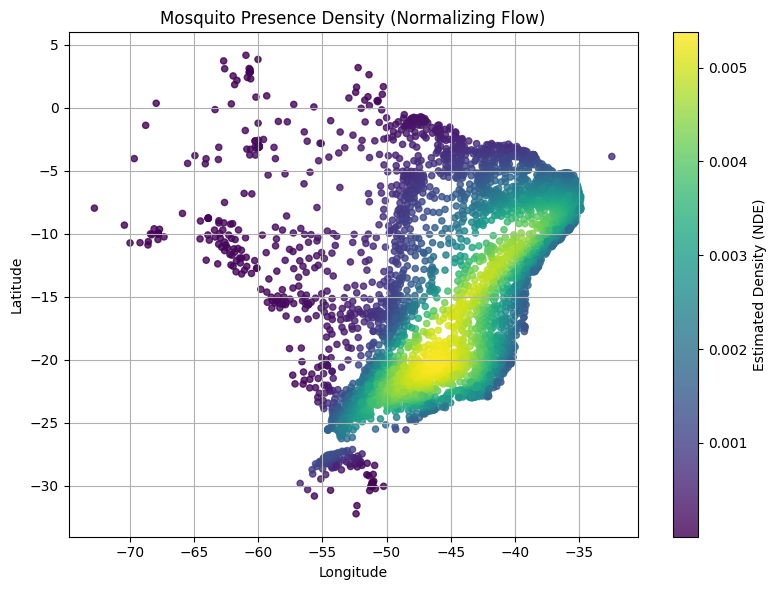

In [357]:
nodata_coords = torch.tensor(nodata[["X", "Y"]].values, dtype=torch.float32)
flow.eval()
with torch.no_grad():
    log_probs = flow.log_prob(nodata_coords)
    probs = torch.exp(log_probs).numpy()
    nodata["nde_prediction"] = probs

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    nodata["X"], nodata["Y"],
    c=nodata["nde_prediction"],
    cmap="viridis",
    s=20,
    alpha=0.8
)
plt.colorbar(scatter, label="Estimated Density (NDE)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Mosquito Presence Density (Normalizing Flow)")
plt.grid(True)
plt.tight_layout()
plt.show()

Device Management (GPU support): For any non-trivial dataset or model size, training on a GPU is essential. Move the flow model to the device (flow.to(device)). Move each batch of data to the device (batch.to(device)).

Permutations/Reversals: While MAATs can theoretically learn complex transformations, stacking identical MAATs without explicit permutations between them might limit the model's expressiveness or require more layers. A common practice is to include a permutation layer (like nflows.transforms.permutations.Reverse or a learned permutation) between autoregressive layers. This shuffles the feature dimensions, ensuring that dependencies learned in one layer are presented in a different order to the next layer.



In [ ]:
pseudo_df = ppd.read_csv('../Datasets/pseudo_data.csv")

In [359]:
pseudo_df.head()

,X,Y,LOCATION_TYPE
0,-52.38,-32.21,presence
1,-52.31,-31.56,presence
2,-55.63,-30.80,presence
3,-51.32,-30.37,presence
4,-54.37,-30.34,presence


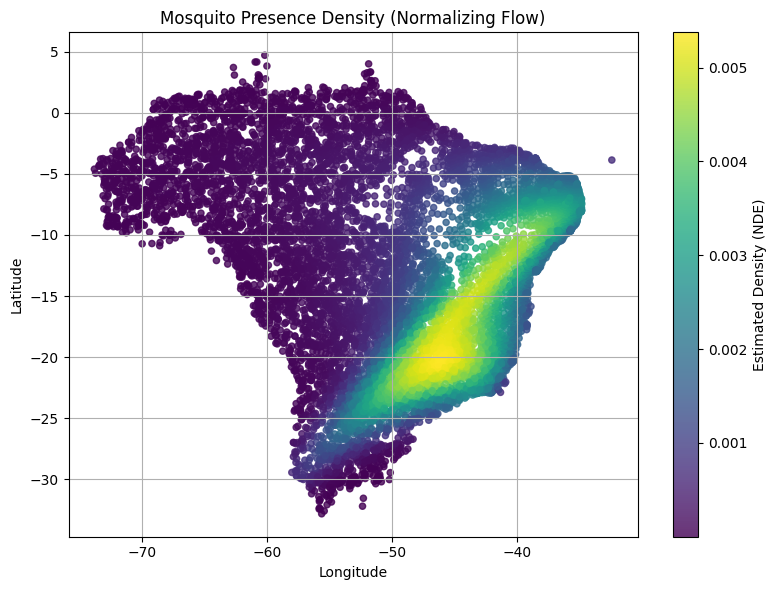

In [360]:
pseudo_coords = torch.tensor(pseudo_df[["X", "Y"]].values, dtype=torch.float32)
flow.eval()
with torch.no_grad():
    log_probs = flow.log_prob(pseudo_coords)
    probs = torch.exp(log_probs).numpy()
    pseudo_df["nde_prediction"] = probs

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    pseudo_df["X"], pseudo_df["Y"],
    c=pseudo_df["nde_prediction"],
    cmap="viridis",
    s=20,
    alpha=0.8
)
plt.colorbar(scatter, label="Estimated Density (NDE)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Mosquito Presence Density (Normalizing Flow)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [361]:
import numpy as np

def boyce_index(pred_presence, pred_background, num_bins=10):
    """
    Compute the continuous Boyce Index.

    Args:
        pred_presence: array-like, predicted densities at true presence locations
        pred_background: array-like, predicted densities at background (nodata) locations
        num_bins: number of bins to group predicted values

    Returns:
        Boyce Index value (Spearman correlation between bin ranks and ratio of presence to background counts)
    """
    # Create bin edges between min and max of background predictions
    bins = np.linspace(pred_background.min(), pred_background.max(), num_bins + 1)

    # Count how many presence and background points fall into each bin
    pres_counts, _ = np.histogram(pred_presence, bins=bins)
    back_counts, _ = np.histogram(pred_background, bins=bins)

    # Calculate ratio: presence / background per bin (avoid divide-by-zero)
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = pres_counts / back_counts
        valid = back_counts > 0
        ratio = ratio[valid]
        bin_ranks = np.arange(len(ratio))

    # Return Spearman correlation if we have at least 2 bins
    if len(ratio) >= 2:
        return np.corrcoef(bin_ranks, ratio)[0, 1]
    else:
        return np.nan


In [362]:
pseudo_df['LOCATION_TYPE'].unique()

array(['presence', 'absense'], dtype=object)

In [363]:
background_df = pseudo_df[pseudo_df['LOCATION_TYPE'] == 'absense']
background_df.reset_index(drop=True, inplace=True)

In [364]:
background_df

,X,Y,LOCATION_TYPE,nde_prediction
0,-51.340323,-21.294093,absense,0.002688
1,-53.815449,-4.460193,absense,0.000331
2,-53.412585,-21.224285,absense,0.000664
3,-46.676435,-19.531162,absense,0.005279
4,-66.217836,-5.086973,absense,0.000089
...,...,...,...,...
4995,-64.510023,-0.473182,absense,0.000056
4996,-45.037822,-21.059833,absense,0.004998
4997,-57.901437,-1.709239,absense,0.000149
4998,-50.088505,-10.347747,absense,0.000774


In [365]:
import torch
import numpy as np

# --- Define Boyce Index function (NumPy-based) ---
def boyce_index(pred_presence, pred_background, num_bins=10):
    """
    Compute the continuous Boyce Index.

    Args:
        pred_presence: array-like, predicted densities at presence locations
        pred_background: array-like, predicted densities at background locations
        num_bins: number of bins to group predicted values

    Returns:
        Boyce Index value (Spearman correlation)
    """
    bins = np.linspace(pred_background.min(), pred_background.max(), num_bins + 1)

    pres_counts, _ = np.histogram(pred_presence, bins=bins)
    back_counts, _ = np.histogram(pred_background, bins=bins)

    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = pres_counts / back_counts
        valid = back_counts > 0
        ratio = ratio[valid]
        bin_ranks = np.arange(len(ratio))

    if len(ratio) >= 2:
        return np.corrcoef(bin_ranks, ratio)[0, 1]
    else:
        return np.nan

# --- Get predictions from NDE (Normalizing Flow) ---
# Assumes you already have your trained `flow` object
# and the presence/background data loaded as pandas DataFrames

# Convert coordinates to torch tensors
presence_tensor = torch.tensor(presence_data[["X", "Y"]].values, dtype=torch.float32).to(device)
background_tensor = torch.tensor(background_df[["X", "Y"]].values, dtype=torch.float32).to(device)

# Get log probabilities (densities) from the flow
flow.eval()  # put model in eval mode
with torch.no_grad():
    log_probs_presence = flow.log_prob(presence_tensor)
    log_probs_background = flow.log_prob(background_tensor)

# Convert log-probs to densities
pred_presence = torch.exp(log_probs_presence)
pred_background = torch.exp(log_probs_background)

# Convert to numpy
pred_presence_np = pred_presence.cpu().numpy()
pred_background_np = pred_background.cpu().numpy()

# --- Compute Boyce Index ---
boyce = boyce_index(pred_presence_np, pred_background_np)
print(f"Boyce Index (NDE): {boyce:.4f}")


Boyce Index (NDE): 0.4831


C:\Users\dzaik\AppData\Local\Temp\ipykernel_35832\3155248734.py:35: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  in_pres = np.logical_and(pred_pres >= lo, pred_pres < hi).sum()
C:\Users\dzaik\AppData\Local\Temp\ipykernel_35832\3155248734.py:36: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  in_bg   = np.logical_and(pred_bg   >= lo, pred_bg   < hi).sum()


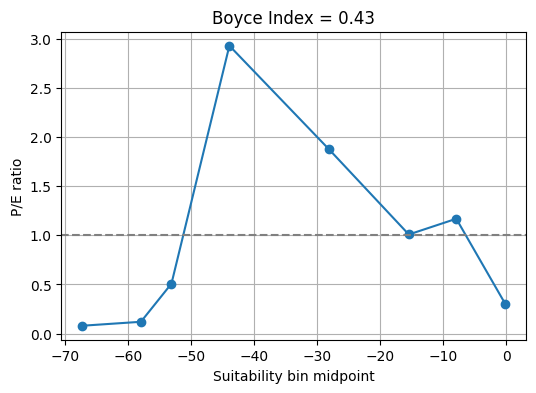

In [366]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def boyce_continuous(pred_pres, pred_bg, num_bins=10, min_pres_per_bin=5, quantile_bins=True):
    """
    Compute continuous Boyce index with optional quantile bins, minimum presences filter,
    and plot the Predicted/Expected (P/E) ratio curve.
    
    Parameters:
        pred_pres (array): Predicted suitability values at presence locations.
        pred_bg   (array): Predicted suitability values at background locations.
        num_bins  (int):   Number of bins (quantile or equal-width).
        min_pres_per_bin (int): Minimum presences required per bin to include it.
        quantile_bins (bool):  Use quantile-based bins if True, else equal-width.
    
    Returns:
        pe_mid (array): Midpoints of retained bins.
        pe_ratio (array): P/E ratios for retained bins.
        boyce_index (float): Spearman correlation between bin midpoints and P/E.
    """
    # Determine bin edges
    if quantile_bins:
        edges = np.quantile(pred_bg, np.linspace(0, 1, num_bins+1))
    else:
        edges = np.linspace(pred_bg.min(), pred_bg.max(), num_bins+1)
        
    pres_counts = []
    bg_counts = []
    bin_mid = []
    
    # Tally counts per bin
    for i in range(num_bins):
        lo, hi = edges[i], edges[i+1]
        in_pres = np.logical_and(pred_pres >= lo, pred_pres < hi).sum()
        in_bg   = np.logical_and(pred_bg   >= lo, pred_bg   < hi).sum()
        
        if in_bg > 0 and in_pres >= min_pres_per_bin:
            pres_counts.append(in_pres)
            bg_counts.append(in_bg)
            bin_mid.append((lo+hi)/2)
    
    pres_counts = np.array(pres_counts)
    bg_counts   = np.array(bg_counts)
    bin_mid     = np.array(bin_mid)
    
    # Predicted/Expected ratio
    pe_ratio = (pres_counts / pres_counts.sum()) / (bg_counts / bg_counts.sum())
    
    # Boyce index: Spearman correlation
    boyce_index, _ = spearmanr(bin_mid, pe_ratio)
    
    # Plot P/E curve
    plt.figure(figsize=(6,4))
    plt.plot(bin_mid, pe_ratio, marker='o', linestyle='-')
    plt.axhline(1, color='gray', linestyle='--')
    plt.xlabel('Suitability bin midpoint')
    plt.ylabel('P/E ratio')
    plt.title(f'Boyce Index = {boyce_index:.2f}')
    plt.grid(True)
    plt.show()
    
    return bin_mid, pe_ratio, boyce_index

# --- Example with dummy data (replace with your real arrays) ---
np.random.seed(0)
presence_preds = torch.tensor(presence_data[["X", "Y"]].values, dtype=torch.float32).to(device)
background_preds = torch.tensor(background_df[["X", "Y"]].values, dtype=torch.float32).to(device)

# Compute and plot
bin_mid, pe_ratio, boyce_idx = boyce_continuous(
    presence_preds, background_preds,
    num_bins=8, min_pres_per_bin=5, quantile_bins=True
)



In [ ]:
df = ppd.read_csv('../Datasets/aegypti.csv")

In [368]:
african_countries = [
    'Nigeria', 'Congo', 'Democratic Republic of the Congo', 'Central African Republic',
    'Cameroon', 'Madagascar', 'Gabon', 'Mayotte', 'R?union', 'Comoros', 'Senegal',
    'Kenya', 'Uganda', 'Sudan', 'Zambia', 'Ghana', 'Burkina Faso', 'Guinea',
    'United Republic of Tanzania', 'Gambia', 'South Africa', 'Mozambique', 'Somalia',
    'Djibouti', 'Zimbabwe', 'Angola', 'Sierra Leone', 'Benin', 'Liberia'
]


In [369]:

africa_df = df[df['COUNTRY'].isin(african_countries)]


In [370]:
presence_points = africa_df[['X', 'Y']].to_numpy()


In [371]:
latitudes = africa_df['Y']
longitudes = africa_df['X']

In [372]:
nodata_coords.shape

torch.Size([4057, 2])

In [373]:
presence_points.T.shape

(2, 546)

In [374]:
africa_df.reset_index(drop=True, inplace=True)

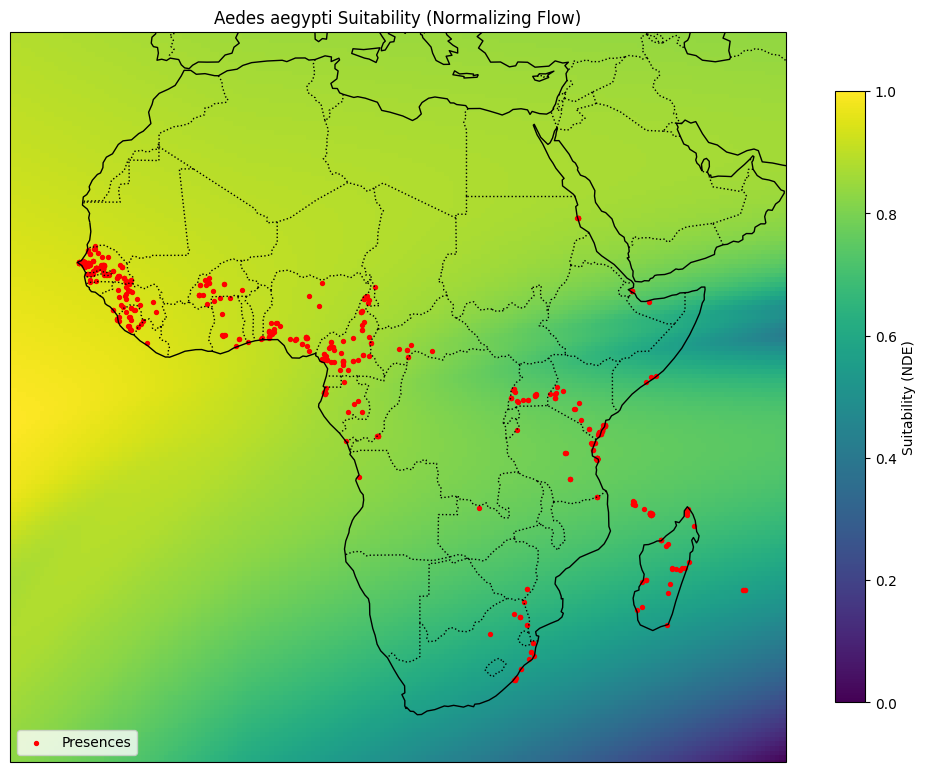

In [375]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assumptions:
#  • flow: your already-trained nflows Flow on raw [X,Y]
#  • africa_df: filtered DataFrame with columns 'X','Y'

# 1) Build a regular lon/lat grid over Africa
lon_vals = np.linspace(-25, 60, 170)   # adjust resolution if you like
lat_vals = np.linspace(-40, 40, 160)
lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)
grid_pts = np.vstack([lon_grid.ravel(), lat_grid.ravel()]).T  # shape (N,2)

# 2) Compute log-densities directly on raw coords
with torch.no_grad():
    # convert to torch.Tensor of shape (N,2)
    t = torch.tensor(grid_pts, dtype=torch.float32)
    logp = flow.log_prob(t).cpu().numpy()   # (N,)

# 3) Rescale logp → [0,1] for visualization
suit = (logp - logp.min()) / (logp.max() - logp.min())
suit = suit.reshape(lon_grid.shape)

# 4) Plot
fig = plt.figure(figsize=(10, 8))
ax  = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-25, 60, -40, 40], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND,      facecolor="lightgray")
ax.add_feature(cfeature.OCEAN,     facecolor="lightblue")
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS,   linestyle=":")

mesh = ax.pcolormesh(
    lon_grid, lat_grid, suit,
    transform=ccrs.PlateCarree(),
    cmap="viridis", shading="auto"
)
cbar = fig.colorbar(mesh, ax=ax, orientation="vertical", shrink=0.8)
cbar.set_label("Suitability (NDE)")

# overlay your red presence dots
ax.scatter(
    africa_df["X"], africa_df["Y"],
    color="red", s=8,
    transform=ccrs.PlateCarree(),
    label="Presences"
)

ax.set_title("Aedes aegypti Suitability (Normalizing Flow)")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()


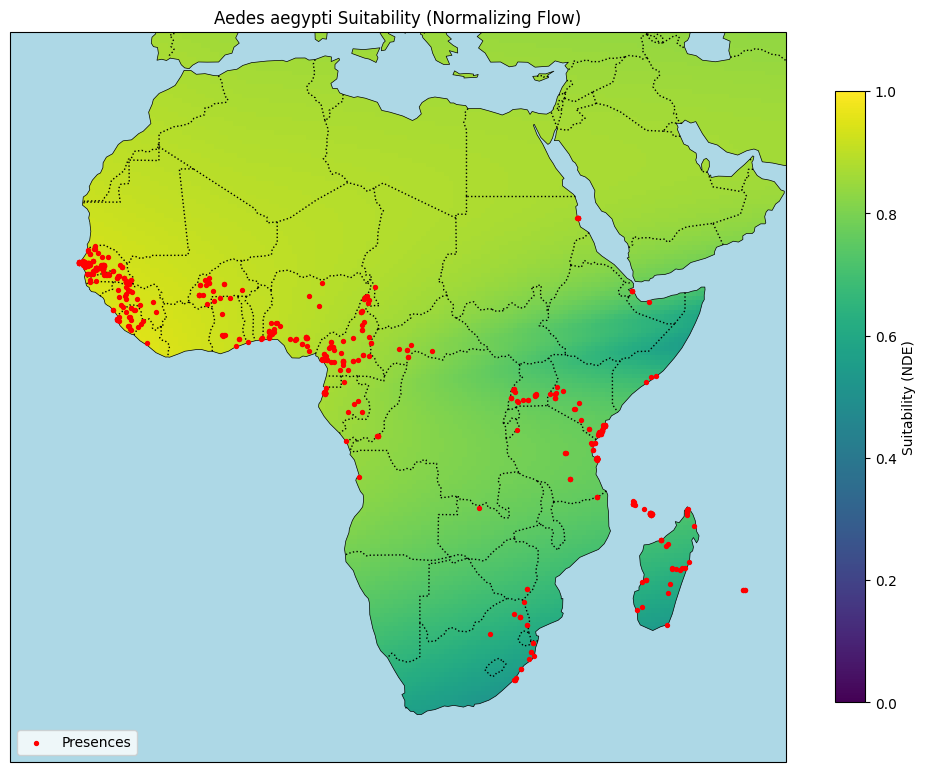

In [376]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

lon_vals = np.linspace(-25, 60, 170)     
lat_vals = np.linspace(-40, 40, 160)
lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)
grid_pts = np.vstack([lon_grid.ravel(), lat_grid.ravel()]).T


with torch.no_grad():
    t = torch.tensor(grid_pts, dtype=torch.float32)       
    logp = flow.log_prob(t).cpu().numpy()                 


suit = (logp - logp.min()) / (logp.max() - logp.min())
suit = suit.reshape(lon_grid.shape)                       
fig = plt.figure(figsize=(10, 8))
ax  = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-25, 60, -40, 40], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)

mesh = ax.pcolormesh(
    lon_grid,
    lat_grid,
    suit,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    shading="auto",
    zorder=1,
)


ax.add_feature(cfeature.OCEAN, facecolor="lightblue", zorder=2)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=3)
ax.add_feature(cfeature.BORDERS, linestyle=":", zorder=3)
cbar = fig.colorbar(mesh, ax=ax, orientation="vertical", shrink=0.8)
cbar.set_label("Suitability (NDE)")

ax.scatter(
    africa_df["X"], 
    africa_df["Y"],
    color="red",
    s=8,
    transform=ccrs.PlateCarree(),
    label="Presences",
    zorder=4
)

ax.set_title("Aedes aegypti Suitability (Normalizing Flow)")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()


# COVARIATES

In [377]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import rioxarray as rxr

import earthpy as et


sns.set(font_scale=1.5, style="white")

In [96]:
import rasterio

raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_water_occurrence.asc"
with rasterio.open(raster_path) as src:
    print(src.crs)


None


In [97]:
from rasterio.crs import CRS
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(
    df_clone,
    geometry=gpd.points_from_xy(df_clone['X'], df_clone['Y']),
    crs="EPSG:4326"
)
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_water_occurrence.asc"
with rasterio.open(raster_path) as src:
    if src.crs is None:
        src_crs = CRS.from_epsg(4326)
    else:
        src_crs = src.crs
    
    # Extracting raster values at point coordinates
    coords = [(point.x, point.y) for point in gdf.geometry]
    values = [val[0] for val in src.sample(coords)]

gdf["water_occurrence"] = values


In [98]:
print("GeoDataFrame CRS:", gdf.crs)

#the dataset with extracted values
print(gdf[["X", "Y", "water_occurrence"]].shape)


GeoDataFrame CRS: EPSG:4326
(5057, 3)


In [99]:
gdf.head()

,Y,X,LOCATION_TYPE,presence,PRES,geometry,water_occurrence
0,-32.21,-52.38,polygon,NaN,True,POINT (-52.38 -32.21),16.0
1,-31.56,-52.31,polygon,1.0,False,POINT (-52.31 -31.56),28.0
2,-30.80,-55.63,polygon,NaN,True,POINT (-55.63 -30.8),3.0
3,-30.37,-51.32,polygon,NaN,True,POINT (-51.32 -30.37),62.0
4,-30.34,-54.37,polygon,NaN,True,POINT (-54.37 -30.34),16.0


In [100]:
brazil_data_with_water = pd.DataFrame(gdf.drop(columns="geometry"))
print(brazil_data_with_water.head())

       Y      X LOCATION_TYPE  presence   PRES  water_occurrence
0 -32.21 -52.38       polygon       NaN   True              16.0
1 -31.56 -52.31       polygon       1.0  False              28.0
2 -30.80 -55.63       polygon       NaN   True               3.0
3 -30.37 -51.32       polygon       NaN   True              62.0
4 -30.34 -54.37       polygon       NaN   True              16.0


In [101]:
brazil_data_with_water.shape

(5057, 6)

In [102]:

gdf = gpd.GeoDataFrame(
    brazil_data_with_water,
    geometry=gpd.points_from_xy(brazil_data_with_water['X'], brazil_data_with_water['Y']),
    crs="EPSG:4326"
)
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_annual_mean_temp_2020_crop_mask.asc"
with rasterio.open(raster_path) as src:
    if src.crs is None:
        src_crs = CRS.from_epsg(4326)
    else:
        src_crs = src.crs
    
    # Extracting raster values at point coordinates
    coords = [(point.x, point.y) for point in gdf.geometry]
    values = [val[0] for val in src.sample(coords)]

gdf["annual_mean_temp"] = values

KeyboardInterrupt: 

In [ ]:
print("GeoDataFrame CRS:", gdf.crs)

#the dataset with extracted values
print(gdf[["X", "Y", "water_occurrence", "annual_mean_temp"]].head())


GeoDataFrame CRS: EPSG:4326
       X      Y  water_occurrence  annual_mean_temp
0 -52.38 -32.21              16.0         18.891666
1 -52.31 -31.56              28.0         18.703333
2 -55.63 -30.80               3.0         18.783333
3 -51.32 -30.37              62.0         19.741667
4 -54.37 -30.34              16.0         19.441666


In [ ]:
new_brazil_data = pd.DataFrame(gdf.drop(columns="geometry"))

In [ ]:
new_brazil_data.head()

,Y,X,LOCATION_TYPE,presence,PRES,water_occurrence,annual_mean_temp
0,-32.21,-52.38,polygon,1.0,False,16.0,18.891666
1,-31.56,-52.31,polygon,1.0,False,28.0,18.703333
2,-30.80,-55.63,polygon,1.0,False,3.0,18.783333
3,-30.37,-51.32,polygon,1.0,False,62.0,19.741667
4,-30.34,-54.37,polygon,1.0,False,16.0,19.441666


In [ ]:
def extract_raster_values(df, raster_path, column_name, x_col='X', y_col='Y', crs_epsg=4326):
    """
    Extracts raster values at each point location from a DataFrame and adds them as a new column.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with coordinate columns.
    - raster_path (str): Path to the raster file (.asc).
    - column_name (str): Name of the new column to add with extracted values.
    - x_col (str): Name of the longitude column.
    - y_col (str): Name of the latitude column.
    - crs_epsg (int): EPSG code of the coordinate reference system (default: 4326).

    Returns:
    - pd.DataFrame: DataFrame with the new column added.
    """
    
    # Converting DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[x_col], df[y_col]),
        crs=f"EPSG:{crs_epsg}"
    )
    
    # Opening the raster
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs if src.crs is not None else CRS.from_epsg(crs_epsg)
        gdf = gdf.to_crs(raster_crs)
        coords = [(point.x, point.y) for point in gdf.geometry]
        values = [val[0] for val in src.sample(coords)]
    
    # Adding the extracted raster values as a new column
    gdf[column_name] = values
    
    # Returning as a regular DataFrame
    return pd.DataFrame(gdf.drop(columns="geometry"))


In [ ]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_urban_built_up_earthenv.asc"
brazil_data_with_eath = extract_raster_values(new_brazil_data, raster_path, "urban_built_up_eartnev")


brazil_data_with_eath[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev"]].head()


,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev
0,-52.38,-32.21,16.0,18.891666,0.0
1,-52.31,-31.56,28.0,18.703333,0.0
2,-55.63,-30.80,3.0,18.783333,0.0
3,-51.32,-30.37,62.0,19.741667,0.0
4,-54.37,-30.34,16.0,19.441666,0.0


In [ ]:
brazil_data_with_eath.shape

(5057, 8)

In [ ]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_Croplands_2019.asc"
brazil_data_with_crop = extract_raster_values(brazil_data_with_eath, raster_path, "croplands")

brazil_data_with_crop[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands
0,-52.38,-32.21,16.0,18.891666,0.0,0.0
1,-52.31,-31.56,28.0,18.703333,0.0,40.0
2,-55.63,-30.80,3.0,18.783333,0.0,0.0
3,-51.32,-30.37,62.0,19.741667,0.0,63.0
4,-54.37,-30.34,16.0,19.441666,0.0,9.0


In [ ]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_pop_density_2020.asc"
brazil_data_with_pop = extract_raster_values(brazil_data_with_crop, raster_path, "pop_density")


brazil_data_with_pop[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands","pop_density"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density
0,-52.38,-32.21,16.0,18.891666,0.0,0.0,0.588867
1,-52.31,-31.56,28.0,18.703333,0.0,40.0,11.132005
2,-55.63,-30.80,3.0,18.783333,0.0,0.0,0.204499
3,-51.32,-30.37,62.0,19.741667,0.0,63.0,0.492814
4,-54.37,-30.34,16.0,19.441666,0.0,9.0,2.771853


In [ ]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_elevation_crop_mask.asc"
brazil_data_with_crop_mask = extract_raster_values(brazil_data_with_pop, raster_path, "crop_mask")


brazil_data_with_crop_mask[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands","pop_density", "crop_mask"]].head()

KeyboardInterrupt: 

In [ ]:
brazil_data_with_crop_mask.head()

,Y,X,LOCATION_TYPE,presence,PRES,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask
0,-32.21,-52.38,polygon,NaN,True,16.0,18.891666,0.0,0.0,0.588867,14.0
1,-31.56,-52.31,polygon,1.0,False,28.0,18.703333,0.0,40.0,11.132005,47.0
2,-30.80,-55.63,polygon,1.0,False,3.0,18.783333,0.0,0.0,0.204499,268.0
3,-30.37,-51.32,polygon,1.0,False,62.0,19.741667,0.0,63.0,0.492814,14.0
4,-30.34,-54.37,polygon,NaN,True,16.0,19.441666,0.0,9.0,2.771853,102.0


In [ ]:
new_brazil_data_cov = pd.DataFrame(gdf.drop(columns="geometry"))

In [ ]:

new_brazil_data_cov.head()

,Y,X,LOCATION_TYPE,presence,PRES,water_occurrence,annual_mean_temp
0,-32.21,-52.38,polygon,NaN,True,16.0,18.891666
1,-31.56,-52.31,polygon,1.0,False,28.0,18.703333
2,-30.80,-55.63,polygon,1.0,False,3.0,18.783333
3,-30.37,-51.32,polygon,1.0,False,62.0,19.741667
4,-30.34,-54.37,polygon,NaN,True,16.0,19.441666


In [ ]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_precipitation_mean_2023_crop_mask.asc"
brazil_data_with_precip = extract_raster_values(brazil_data_with_crop_mask, raster_path, "precipitation_mean")

brazil_data_with_precip[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands","pop_density", "crop_mask", "precipitation_mean"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-52.38,-32.21,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
1,-52.31,-31.56,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-55.63,-30.80,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-51.32,-30.37,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
4,-54.37,-30.34,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323


In [ ]:
brazil_data_with_precip.head()

,Y,X,LOCATION_TYPE,presence,PRES,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-32.21,-52.38,polygon,NaN,True,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
1,-31.56,-52.31,polygon,1.0,False,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-30.80,-55.63,polygon,1.0,False,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-30.37,-51.32,polygon,1.0,False,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
4,-30.34,-54.37,polygon,NaN,True,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323


In [ ]:
presence_data = brazil_data_with_precip[brazil_data_with_precip["presence"].notna()]
nodata = brazil_data_with_precip[brazil_data_with_precip["presence"].isna()]


In [ ]:
nodata = brazil_data_with_precip[brazil_data_with_precip["presence"].isna()]

In [ ]:
nodata.head()

,Y,X,LOCATION_TYPE,presence,PRES,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-32.21,-52.38,polygon,NaN,True,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
4,-30.34,-54.37,polygon,NaN,True,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323
5,-30.29,-56.16,polygon,NaN,True,0.0,19.674999,0.0,0.0,0.169102,199.0,4.302065
6,-30.21,-50.87,polygon,NaN,True,0.0,19.891666,0.0,3.0,1.521041,45.0,4.435313
10,-30.00,-51.06,polygon,NaN,True,0.0,20.870001,35.0,2.0,7407.009766,10.0,4.409069


In [ ]:
presence_data.head()

,Y,X,LOCATION_TYPE,presence,PRES,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
1,-31.56,-52.31,polygon,1.0,False,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-30.80,-55.63,polygon,1.0,False,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-30.37,-51.32,polygon,1.0,False,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
7,-30.17,-51.44,polygon,1.0,False,52.0,19.913334,0.0,15.0,3.718940,62.0,4.120785
8,-30.10,-51.16,polygon,1.0,False,11.0,19.633333,0.0,0.0,200.926620,144.0,4.426367


In [ ]:
nodata = nodata.drop("PRES", axis=1)

In [ ]:
nodata.head()

,Y,X,LOCATION_TYPE,presence,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-32.21,-52.38,polygon,NaN,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
4,-30.34,-54.37,polygon,NaN,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323
5,-30.29,-56.16,polygon,NaN,0.0,19.674999,0.0,0.0,0.169102,199.0,4.302065
6,-30.21,-50.87,polygon,NaN,0.0,19.891666,0.0,3.0,1.521041,45.0,4.435313
10,-30.00,-51.06,polygon,NaN,0.0,20.870001,35.0,2.0,7407.009766,10.0,4.409069


In [ ]:
presence_data = presence_data.drop("PRES", axis=1)

In [ ]:
presence_data.head()

,Y,X,LOCATION_TYPE,presence,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
1,-31.56,-52.31,polygon,1.0,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-30.80,-55.63,polygon,1.0,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-30.37,-51.32,polygon,1.0,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
7,-30.17,-51.44,polygon,1.0,52.0,19.913334,0.0,15.0,3.718940,62.0,4.120785
8,-30.10,-51.16,polygon,1.0,11.0,19.633333,0.0,0.0,200.926620,144.0,4.426367


In [ ]:
nodata.fillna(0)

,Y,X,LOCATION_TYPE,presence,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-32.21,-52.38,polygon,0.0,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
4,-30.34,-54.37,polygon,0.0,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323
5,-30.29,-56.16,polygon,0.0,0.0,19.674999,0.0,0.0,0.169102,199.0,4.302065
6,-30.21,-50.87,polygon,0.0,0.0,19.891666,0.0,3.0,1.521041,45.0,4.435313
10,-30.00,-51.06,polygon,0.0,0.0,20.870001,35.0,2.0,7407.009766,10.0,4.409069
...,...,...,...,...,...,...,...,...,...,...,...
5050,-3.75,-38.58,point,0.0,0.0,28.011667,100.0,3.0,6433.074707,25.0,3.503871
5052,-2.41,-48.15,point,0.0,48.0,27.146667,13.0,0.0,1740.925415,23.0,6.506164
5053,-2.58,-51.91,point,0.0,6.0,26.966667,0.0,0.0,1.384313,52.0,5.690430
5054,2.41,-60.86,point,0.0,2.0,27.398333,0.0,6.0,0.505587,63.0,4.620371


In [ ]:

feature_cols = ["X", "Y"] + [
    "water_occurrence",
    "annual_mean_temp",
    "urban_built_up_eartnev",
    "croplands",
    "pop_density",
    "crop_mask",
    "precipitation_mean"
]


presence_data = presence_data[feature_cols].values
X = torch.tensor(presence_data, dtype=torch.float32)  


dataset = DataLoader(TensorDataset(X), batch_size=128, shuffle=True)
flow = create_flow(input_dim=X.shape[1], hidden_features=64, num_layers=5).to(device)


In [ ]:
X.shape[1]

9

In [ ]:
import numpy as np

print("Any NaNs?", np.isnan(presence_data).any())
print("Any Infs?", np.isinf(presence_data).any())


Any NaNs? False
Any Infs? False


In [ ]:
type(presence_data)


numpy.ndarray

In [ ]:
import numpy as np

# Check for nan or infinite values in presence_data
if np.any(np.isnan(presence_data)) or np.any(np.isinf(presence_data)):
    print("Data contains nan or infinite values. Cleaning data...")
    presence_data = np.nan_to_num(presence_data, nan=0.0, posinf=1e6, neginf=-1e6)  # Replace with reasonable defaults

In [ ]:
X = torch.tensor(presence_data, dtype=torch.float32)
dataset = DataLoader(TensorDataset(X), batch_size=128, shuffle=True)

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Assuming feature_cols and presence_data are already defined
feature_cols = ["X", "Y"] + [

    "pop_density",
    "precipitation_mean",
    "water_occurence"
]

# Split into target and covariate columns
covariate_cols = ["pop_density",
    "precipitation_mean", "water_occurence"]
target_cols = [col for col in feature_cols if col not in covariate_cols]

# Get the integer indices of target_cols and covariate_cols in feature_cols
target_indices = [feature_cols.index(col) for col in target_cols]
covariate_indices = [feature_cols.index(col) for col in covariate_cols]

# Index presence_data using integer indices
target_data = presence_data[:, target_indices]
covariate_data = presence_data[:, covariate_indices]

# Normalize the data
scaler = StandardScaler()
target_data = scaler.fit_transform(target_data)
covariate_data = scaler.fit_transform(covariate_data)

# Convert to tensors
X_target = torch.tensor(target_data, dtype=torch.float32)
X_covariate = torch.tensor(covariate_data, dtype=torch.float32)
dataset = DataLoader(TensorDataset(X_target, X_covariate), batch_size=128, shuffle=True)

In [ ]:
pip install --upgrade nflows

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import inspect
from nflows.flows.base import Flow
print(inspect.signature(Flow.log_prob))

(self, inputs, context=None)


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils import clip_grad_norm_
from sklearn.preprocessing import StandardScaler
from nflows.distributions.normal import StandardNormal
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.permutations import RandomPermutation
from nflows.transforms.normalization import BatchNorm
from nflows.flows.base import Flow

# Custom Conditional Masked Affine Autoregressive Transform
class ConditionalMaskedAffineAutoregressiveTransform(MaskedAffineAutoregressiveTransform):
    def __init__(self, features, hidden_features, context_features, num_blocks=2, use_residual_blocks=True, random_mask=False):
        super().__init__(features=features, hidden_features=hidden_features, num_blocks=num_blocks,
                        use_residual_blocks=use_residual_blocks, random_mask=random_mask)
        self.context_features = context_features
        # Context encoder (MLP) to process covariates
        self.context_net = nn.Sequential(
            nn.Linear(context_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, features * 2)  # Output scale and shift for each feature
        )

    def forward(self, inputs, context=None, **kwargs):
        if context is None:
            return super().forward(inputs, **kwargs)
        
        # Process context to get scale and shift
        context_params = self.context_net(context)
        shift, log_scale = context_params.chunk(2, dim=-1)
        scale = torch.sigmoid(log_scale + 2.)  # Ensure scale is positive

        # Combine with the autoregressive transform
        outputs, logabsdet = super().forward(inputs, **kwargs)
        outputs = outputs + shift
        logabsdet = logabsdet + torch.log(scale).sum(dim=-1)
        return outputs * scale, logabsdet

    def inverse(self, inputs, context=None, **kwargs):
        if context is None:
            return super().inverse(inputs, **kwargs)
        
        context_params = self.context_net(context)
        shift, log_scale = context_params.chunk(2, dim=-1)
        scale = torch.sigmoid(log_scale + 2.)

        inputs = inputs / scale - shift
        return super().inverse(inputs, **kwargs)

# Feature columns
feature_cols = ["X", "Y"] + [
    "water_occurrence",
    # "annual_mean_temp",
    # "urban_built_up_eartnev",
    # "croplands",
    "pop_density",
    # "crop_mask",
    "precipitation_mean"
]

# Assuming presence_data is already defined as a DataFrame or NumPy array
if not isinstance(presence_data, np.ndarray):
    presence_data = presence_data[feature_cols].values

# Check and clean data for nan or infinite values
if np.any(np.isnan(presence_data)) or np.any(np.isinf(presence_data)):
    print("Data contains nan or infinite values. Cleaning data...")
    presence_data = np.nan_to_num(presence_data, nan=0.0, posinf=1e6, neginf=-1e6)

# Split into target and covariate columns
covariate_cols = ["pop_density", "precipitation_mean"]
target_cols = [col for col in feature_cols if col not in covariate_cols]

# Get the integer indices of target_cols and covariate_cols in feature_cols
target_indices = [feature_cols.index(col) for col in target_cols]
covariate_indices = [feature_cols.index(col) for col in covariate_cols]

# Index presence_data using integer indices
target_data = presence_data[:, target_indices]
covariate_data = presence_data[:, covariate_indices]

# Normalize the data
scaler = StandardScaler()
target_data = scaler.fit_transform(target_data)
covariate_data = scaler.fit_transform(covariate_data)

# Convert to tensors
X_target = torch.tensor(target_data, dtype=torch.float32)
X_covariate = torch.tensor(covariate_data, dtype=torch.float32)
dataset = DataLoader(TensorDataset(X_target, X_covariate), batch_size=128, shuffle=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create flow with custom conditional transform
def create_flow(input_dim=len(target_cols), covariate_dim=len(covariate_cols), hidden_features=64, num_layers=5):
    transforms = []
    for _ in range(num_layers):
        transforms.append(ConditionalMaskedAffineAutoregressiveTransform(
            features=input_dim,
            hidden_features=hidden_features,
            context_features=covariate_dim
        ))
        transforms.append(RandomPermutation(features=input_dim))
        transforms.append(BatchNorm(features=input_dim))

    transform = CompositeTransform(transforms)
    base_dist = StandardNormal(shape=[input_dim])
    return Flow(transform, base_dist)

# Initialize flow
flow = create_flow().to(device)

# Initialize weights for better stability
def initialize_weights(module):
    if isinstance(module, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)

flow.apply(initialize_weights)

# Optimizer and scheduler
optimizer = Adam(flow.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Training loop with context support
def train_nf(flow, dataset, optimizer, n_epochs=50, device=device):
    flow.train()
    for epoch in range(n_epochs):
        total_loss = 0
        num_batches = 0
        for batch in dataset:
            target_data, covariate_data = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()
            # Use context argument in log_prob
            log_prob = flow.log_prob(inputs=target_data, context=covariate_data)
            if torch.any(torch.isnan(log_prob)) or torch.any(torch.isinf(log_prob)):
                print(f"NaN or Inf detected in log_prob at Epoch {epoch+1}. Check data or model stability.")
                return
            loss = -log_prob.mean()

            loss.backward()
            clip_grad_norm_(flow.parameters(), max_norm=0.5)

            optimizer.step()
            total_loss += loss.item()
            num_batches += 1

        scheduler.step()
        print(f"Epoch {epoch+1}, Loss: {total_loss / num_batches:.4f}")

# Train the model
train_nf(flow, dataset, optimizer, n_epochs=50, device=device)

Using device: cpu
Epoch 1, Loss: 2.6045
Epoch 2, Loss: 1.7506
Epoch 3, Loss: 1.2912
Epoch 4, Loss: 1.0303
Epoch 5, Loss: 0.8464
Epoch 6, Loss: 0.6039
Epoch 7, Loss: 0.5461
Epoch 8, Loss: 0.5168
Epoch 9, Loss: 0.4637
Epoch 10, Loss: 0.4023
Epoch 11, Loss: 0.3768
Epoch 12, Loss: 0.3023
Epoch 13, Loss: 0.3673
Epoch 14, Loss: 0.1924
Epoch 15, Loss: 0.2209
Epoch 16, Loss: 0.1814
Epoch 17, Loss: 0.2338
Epoch 18, Loss: 0.1144
Epoch 19, Loss: 0.1523
Epoch 20, Loss: 0.0777
Epoch 21, Loss: 0.0509
Epoch 22, Loss: 0.0329
Epoch 23, Loss: 0.0004
Epoch 24, Loss: -0.0031
Epoch 25, Loss: -0.0695
Epoch 26, Loss: -0.0878
Epoch 27, Loss: -0.1367
Epoch 28, Loss: -0.1448
Epoch 29, Loss: -0.2177
Epoch 30, Loss: -0.2555
Epoch 31, Loss: -0.3065
Epoch 32, Loss: -0.3578
Epoch 33, Loss: -0.3568
Epoch 34, Loss: -0.3421
Epoch 35, Loss: -0.3613
Epoch 36, Loss: -0.3901
Epoch 37, Loss: -0.3695
Epoch 38, Loss: -0.3160
Epoch 39, Loss: -0.3128
Epoch 40, Loss: -0.3930
Epoch 41, Loss: -0.4007
Epoch 42, Loss: -0.4174
Epoch 

In [ ]:
# Recreate training data (same as before)
feature_cols = ["X", "Y"] + [
    "water_occurrence",
    # "annual_mean_temp",
    # "urban_built_up_eartnev",
    # "croplands",
    "pop_density",
    # "crop_mask",
    "precipitation_mean"
]

# Assuming presence_data is already defined
if not isinstance(presence_data, np.ndarray):
    presence_data = presence_data[feature_cols].values

# Clean data
if np.any(np.isnan(presence_data)) or np.any(np.isinf(presence_data)):
    print("Data contains nan or infinite values. Cleaning data...")
    presence_data = np.nan_to_num(presence_data, nan=0.0, posinf=1e6, neginf=-1e6)

# Split into target and covariate columns
covariate_cols = ["pop_density", "precipitation_mean"]
target_cols = [col for col in feature_cols if col not in covariate_cols]
target_indices = [feature_cols.index(col) for col in target_cols]
covariate_indices = [feature_cols.index(col) for col in covariate_cols]

target_data = presence_data[:, target_indices]  # Shape: (n_samples, 7)
covariate_data = presence_data[:, covariate_indices]  # Shape: (n_samples, 2)

# Create and fit two separate scalers
target_scaler = StandardScaler()
covariate_scaler = StandardScaler()

target_data = target_scaler.fit_transform(target_data)  # Fit on target_data (7 features)
covariate_data = covariate_scaler.fit_transform(covariate_data)  # Fit on covariate_data (2 features)

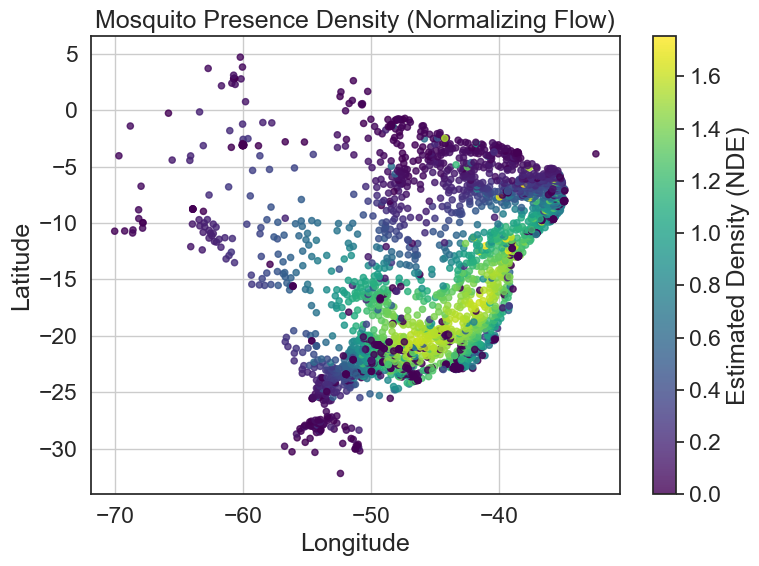

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Step 1: Prepare the nodata inputs (target variables and covariates)
# Extract all relevant features from nodata
nodata_features = nodata[feature_cols].values

# Split into target and covariate features
nodata_target = nodata_features[:, target_indices]  # Shape: (n_samples, 7)
nodata_covariates = nodata_features[:, covariate_indices]  # Shape: (n_samples, 2)

# Step 2: Normalize the data using the correct scalers
nodata_target = target_scaler.transform(nodata_target)  # Use target_scaler (expects 7 features)
nodata_covariates = covariate_scaler.transform(nodata_covariates)  # Use covariate_scaler (expects 2 features)

# Convert to tensors
nodata_target_tensor = torch.tensor(nodata_target, dtype=torch.float32).to(device)
nodata_covariates_tensor = torch.tensor(nodata_covariates, dtype=torch.float32).to(device)

# Step 3: Compute log-probabilities using the flow
flow.eval()
with torch.no_grad():
    log_probs = flow.log_prob(inputs=nodata_target_tensor, context=nodata_covariates_tensor)
    probs = torch.exp(log_probs).cpu().numpy()  # Convert to probabilities

# Step 4: Add predictions to the nodata DataFrame
nodata["nde_prediction"] = probs

# Step 5: Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    nodata["X"], nodata["Y"],
    c=nodata["nde_prediction"],
    cmap="viridis",
    s=20,
    alpha=0.8
)
plt.colorbar(scatter, label="Estimated Density (NDE)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Mosquito Presence Density (Normalizing Flow)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import rasterio
import numpy as np
import os
tif_folder = r"C:\Users\dzaik\Downloads\MSC_thesis\Rumbi\2020"

tif_files = sorted([os.path.join(tif_folder, f) for f in os.listdir(tif_folder) if f.endswith('.tif')])

with rasterio.open(tif_files[0]) as src:
    meta = src.meta.copy()
    annual_data = src.read(1)

for tif in tif_files[1:]:
    with rasterio.open(tif) as src:
        annual_data += src.read(1)

annual_precip_path = "aggregated_2020_precip.tif"
meta.update(dtype=rasterio.float32)

with rasterio.open(annual_precip_path, "w", **meta) as dst:
    dst.write(annual_data.astype(rasterio.float32), 1)

In [ ]:
africa_df = extract_raster_values(
    africa_df,
    "aggregated_2020_precip.tif",
    column_name="precipitation_mean"
)

africa_df = extract_raster_values(
    africa_df,
    r"C:\Users\dzaik\Downloads\MSC_thesis\Rumbi\gpw_v4_population_density_rev11_2020_30_sec_2020.tif",
    column_name="pop_density"
)

# africa_df = extract_raster_values(
#     africa_df,
#     r"C:\Users\dzaik\Downloads\MSC_thesis\Rumbi _temp_water\Complete_TAVG_LatLong1(temperature).nc",
#     column_name=""
# )

africa_df = extract_raster_values(
    africa_df,
    r"C:\Users\dzaik\Downloads\MSC_thesis\Rumbi _temp_water\GWP.OSWF.ANNUAL.2020.v1(water_occurrence).tif",
    column_name="water_occurrence"
)







In [ ]:
africa_df.head()

,VECTOR,OCCURRENCE_ID,SOURCE_TYPE,LOCATION_TYPE,POLYGON_ADMIN,Y,X,YEAR,COUNTRY,COUNTRY_ID,GAUL_AD0,STATUS,precipitation_mean,pop_density,water_occurrence
0,Aedes aegypti,14447,18118,Less than 25km,Less than 25km,7.77,4.57,2011.0,Nigeria,NGA,182,NaN,1197.500000,2348.919434,0
1,Aedes aegypti,14448,18119,point,-999,-4.31,15.19,2011.0,Congo,COG,59,NaN,1702.300049,0.476689,0
2,Aedes aegypti,14449,18119,point,-999,-4.26,15.20,2011.0,Congo,COG,59,NaN,1725.699951,0.476689,0
3,Aedes aegypti,14474,18131,point,-999,4.37,18.55,2010.0,Central African Republic,CAF,49,NaN,1416.899902,27038.519531,0
4,Aedes aegypti,14475,18131,Less than 100km,Less than 100km,5.05,21.20,2010.0,Central African Republic,CAF,49,NaN,1498.099976,404.273468,0


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 1. Clean Africa data (only rows with all needed covariates)
required_cols = ["X", "Y", "pop_density", "precipitation_mean","water_occurrence"]
africa_clean = africa_df.dropna(subset=required_cols).copy()

# 2. Extract and scale covariates and targets
X_cov_africa = africa_clean[["pop_density", "precipitation_mean,", "water_occurrence"]].values
X_tgt_africa = africa_clean[["X", "Y"]].values

X_cov_scaled = scaler.fit_transform(X_cov_africa)
X_tgt_scaled = scaler.fit_transform(X_tgt_africa)

X_cov_tensor = torch.tensor(X_cov_scaled, dtype=torch.float32).to(device)
X_tgt_tensor = torch.tensor(X_tgt_scaled, dtype=torch.float32).to(device)

# 3. Predict using trained flow
flow.eval()
with torch.no_grad():
    log_prob = flow.log_prob(inputs=X_tgt_tensor, context=X_cov_tensor).cpu().numpy()

# 4. Normalize prediction for visualization
suitability = (log_prob - log_prob.min()) / (log_prob.max() - log_prob.min())
africa_clean["suitability"] = suitability


KeyError: "['precipitation_mean,'] not in index"

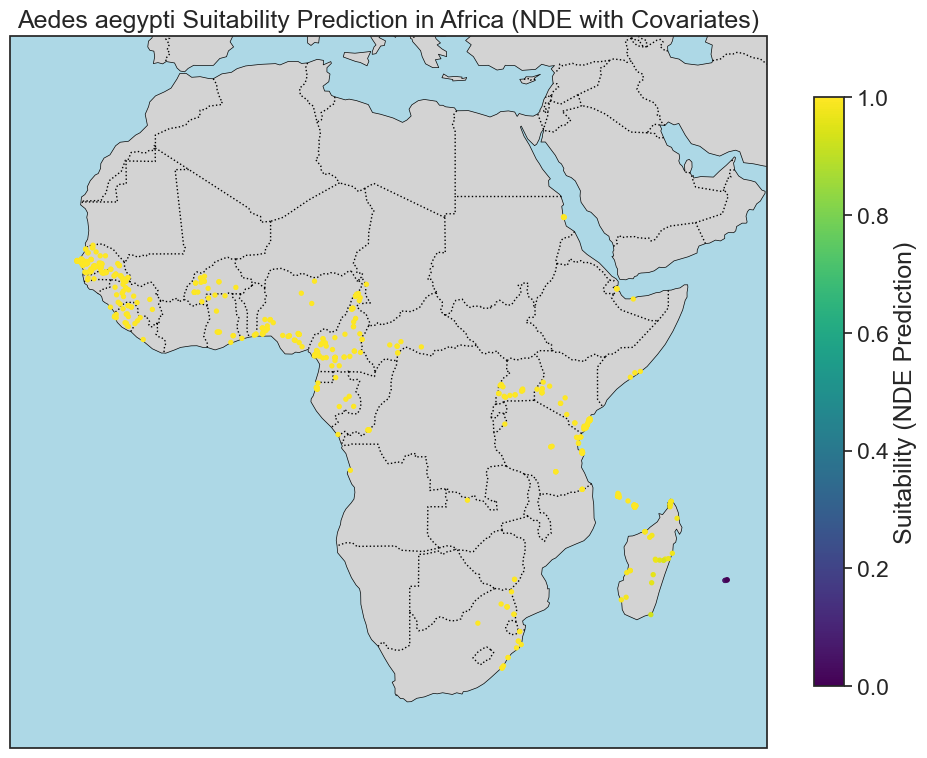

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-25, 60, -40, 40], crs=ccrs.PlateCarree())

# Map features
ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor="lightblue", zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=2)
ax.add_feature(cfeature.BORDERS, linestyle=":", zorder=2)

# Plot predicted suitability
scatter = ax.scatter(
    africa_clean["X"],
    africa_clean["Y"],
    c=africa_clean["suitability"],
    cmap="viridis",
    s=8,
    transform=ccrs.PlateCarree(),
    zorder=3
)

# Colorbar and title
cbar = plt.colorbar(scatter, ax=ax, orientation="vertical", shrink=0.8)
cbar.set_label("Suitability (NDE Prediction)")

ax.set_title("Aedes aegypti Suitability Prediction in Africa (NDE with Covariates)")
plt.tight_layout()
plt.show()
